In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
folder_base = '/Users/emiliebertholet/cernbox/coldbox_data'

In [3]:
!ls /Users/emiliebertholet/cernbox/coldbox_data

adc_data_run_25036_ch_40_all.npy adc_data_run_25068_ch_37_all.npy
adc_data_run_25050_ch_37_all.npy adc_data_run_25071_ch_37_all.npy
adc_data_run_25066_ch_40_all.npy adc_data_run_25087_ch_37_all.npy


In [4]:
filename = f'{folder_base}/adc_data_run_25036_ch_40_all.npy'
data = np.load(filename, allow_pickle=True).astype(np.int16)
data.shape
# (16600, 65536): 16600 = "rows"; 65536 = "columns"

(16600, 65536)

In [5]:
def fast_plot(data):
    fig, axs = plt.subplots(1, 1, figsize=(12, 2))
    axs.plot(data.transpose())
    axs.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
    axs.set_ylabel(r"$\mathrm{\bf ADC\ counts}$");

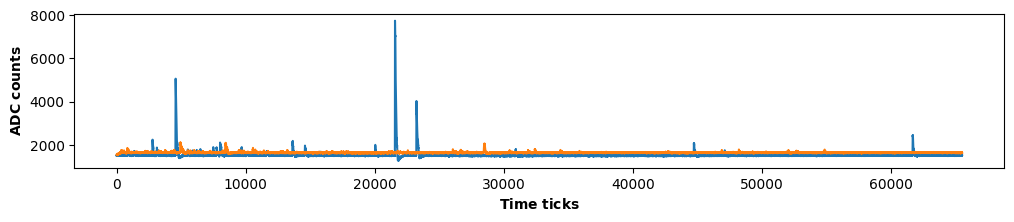

In [6]:
fast_plot(data[0:2])

In [12]:
from scipy.signal import find_peaks
import gc

def substract_peds(row):
    return row - np.argmax(np.bincount(row))

def filter_rows(data, param, threshold=0, window_size=0):
  # print(data.shape[0])
  # print(data.shape[1])
  filtered_data = []
  peak_data = []
  for row in data:
      row = substract_peds(row)
      if 400 < np.max(row) < 12.5e3:
          filtered_data.append(row)
  filtered_data = np.array(filtered_data)
  # print(filtered_data.shape[0])
  # print(filtered_data.shape[1])
  del data
  gc.collect()
  for row in filtered_data:
    if param == 1:
      index_range = slice(100, 1900)
      peaks, _ = find_peaks(row[index_range], height=100)
      peaks = peaks + index_range.start
    else:
      index_range = slice(100, 52000)
      peaks, _ = find_peaks(row[index_range], height=100)
      peaks = peaks + index_range.start
    # print(len(peaks))
    for i, peak in enumerate(peaks):
      if peak in (0, len(row) - 1) or (i > 0 and peaks[i - 1] == peak - 1) or (i < len(peaks) - 1 and peaks[i + 1] == peak + 1):
        continue
      threshold = 0.1 * row[peak]
      left_edge_ind = peak
      while left_edge_ind > max(0, peak-100) and row[left_edge_ind] > threshold:
        left_edge_ind -= 1
      right_edge_ind = peak
      while right_edge_ind < min(len(row)-1, peak+100) and row[right_edge_ind] > threshold:
        right_edge_ind += 1
      if row[left_edge_ind] <= threshold and row[right_edge_ind] <= threshold:
        peak_data.append(row[left_edge_ind:right_edge_ind])
  # print(len(peak_data))
  del filtered_data
  gc.collect()
  return peak_data

# Load in Chunks

In [ ]:
# # filename = '/content/drive/MyDrive/lab_adi/adc_data_run_25036_ch_40_all.npy'
# folder_base = '../../coldbox_data'
# filename = f'{folder_base}/adc_data_run_25036_ch_40_all.npy'
# chunk_size = 500
# threshold = 100
# num_columns = 1150
# window_size = 500
# # output_file = '/content/drive/MyDrive/lab_adi/processed_data_positive.csv'
# output_file = f'{folder_base}/processed_data_positive.csv'

# with open(output_file, 'w') as f:
#     pd.DataFrame().to_csv(f, index=False)

# for i, chunk in enumerate(load_in_chunks(filename, chunk_size, 1, None)):
#     processed_chunk = features_extraction(chunk)
#     # print(processed_chunk.shape)
#     if i == 0:
#         processed_chunk.to_csv(output_file, mode='a', header=True, index=False)
#     else:
#         processed_chunk.to_csv(output_file, mode='a', header=False, index=False)

In [8]:
def load_in_chunks(filename, chunk_size, param, upper_limit = None):
    data = np.load(filename, mmap_mode='r').astype(np.int16)
    data[data < 0] = 0
    data = filter_rows(data, param)
    plt.plot(data[0])
    plt.show()
    plt.plot(data[40])
    plt.show()
    plt.plot(data[50])
    plt.show()
    plt.plot(data[70])
    plt.show()
    total_size = len(data)
    for start in range(0, total_size, chunk_size):
        end = min(start + chunk_size, total_size) if upper_limit is None else min(start + chunk_size, upper_limit, total_size)
        chunk = pd.DataFrame(data[start:end])
        chunk = chunk[(chunk != 0).any(axis=1)]
        if not chunk.empty:
            yield chunk

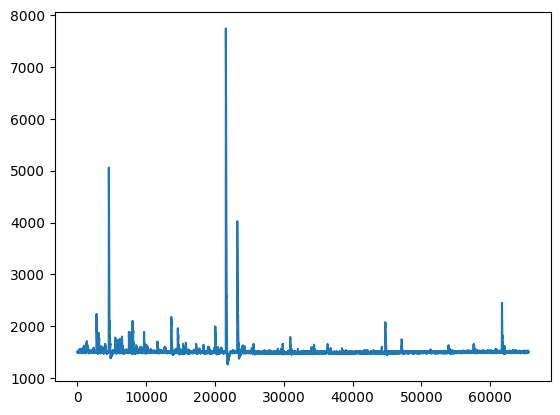

In [9]:
plt.plot(data[0])

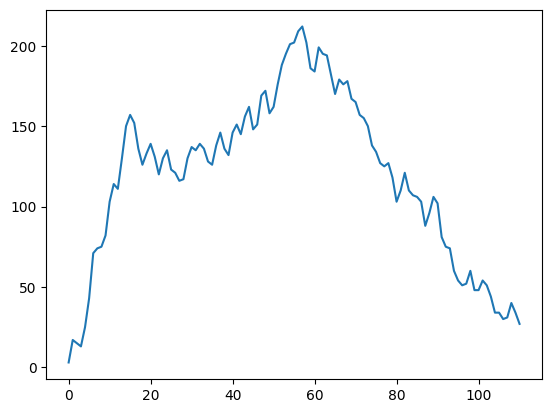

In [13]:
data[data < 0] = 0
dataf = filter_rows(data, 1)
plt.plot(dataf[0]);

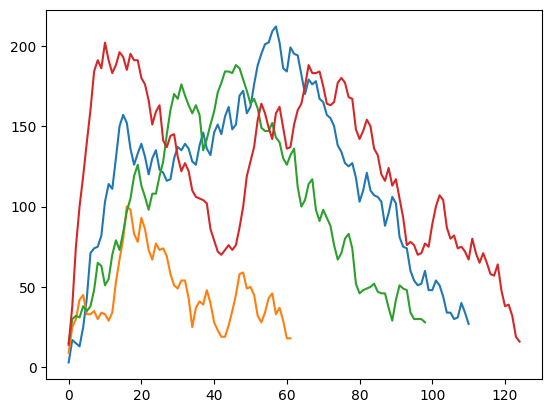

In [17]:
plt.plot(dataf[0]);
plt.plot(dataf[40]);
plt.plot(dataf[50]);
plt.plot(dataf[70]);